In [1]:
!pip install kaggle
!pip install pillow
import json
import pandas as pd
import tqdm as tqdm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from PIL import Image
import tensorflow as tf


In [2]:
api_token = {"username":"twoface262","key":"453e89deca1ef616f15f5725eed93000"}

with open('kaggle.json', 'w') as kaggle_json:
  json.dump(api_token, kaggle_json)
  
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Dataset source: https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels
# Attributes: Jaeger S, Karargyris A, Candemir S, Folio L, Siegelman J, Callaghan F, Xue Z, Palaniappan K, Singh RK, Antani S, Thoma G, Wang YX, Lu PX, McDonald CJ. Automatic tuberculosis screening using chest radiographs. IEEE Trans Med Imaging. 2014 Feb;33(2):233-45. doi: 10.1109/TMI.2013.2284099. PMID: 24108713 Candemir S, Jaeger S, Palaniappan K, Musco JP, Singh RK, Xue Z, Karargyris A, Antani S, Thoma G, McDonald CJ. Lung segmentation in chest radiographs using anatomical atlases with nonrigid registration. IEEE Trans Med Imaging. 2014 Feb;33(2):577-90. doi: 10.1109/TMI.2013.2290491. PMID: 24239990 Montgomery County X-ray Set X-ray images in this data set have been acquired from the tuberculosis control program of the Department of Health and Human Services of Montgomery County, MD, USA. This set contains 138 posterior-anterior x-rays, of which 80 x-rays are normal and 58 x-rays are abnormal with manifestations of tuberculosis. All images are de-identified and available in DICOM format. The set covers a wide range of abnormalities, including effusions and miliary patterns. The data set includes radiology readings available as a text file.
!kaggle datasets download nikhilpandey360/chest-xray-masks-and-labels
!ls

100% 4.78G/4.79G [01:28<00:00, 76.5MB/s]
100% 4.79G/4.79G [01:28<00:00, 58.1MB/s]
chest-xray-masks-and-labels.zip  kaggle.json  sample_data


In [0]:
!mkdir data_train
!unzip chest-xray-masks-and-labels.zip -d data_train

In [0]:
!ls data_train/Lung\ Segmentation/ClinicalReadings

file_x = open("data_train/Lung Segmentation/ClinicalReadings/CHNCXR_0613_1.txt")
print(file_x.read())




We have to base the label off of the name. 0 indicates normal and 1 indicates PTB.

We should first load in the iamges and label them. We can label them as 0 for normal and 1 for PTB (single labeled, but will be fine)

In [5]:
!ls data_train/Lung\ Segmentation

ClinicalReadings  masks			       NLM-MontgomeryCXRSet-ReadMe.pdf
CXR_png		  NLM-ChinaCXRSet-ReadMe.docx  test


In [0]:

# Authors: Wezley Sherman
#
# Reference Attributes: Pydicom documentation, glob documentation
# https://pydicom.github.io/pydicom/stable/getting_started.html
# https://pymotw.com/2/glob/
#
# This class is a part of the BSSCS Net Framework to import DICOM images
#
# BSSCS Docs Importer location: BSSCS_DOCS/dicom.html
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import math
import os

class UNET_DATA:
  def __init__(self,label_classes, batch_size=2, labels_arr=None, image_arr=None, csv_path=None, images_path=None):
    self.current_batch = 0
    self.current_idx = 0
    self.batch_size = batch_size
    self.total_batches = 500
    self.labels = labels_arr
    self.images = image_arr
    self.label_classes = label_classes
    self.images_path = images_path

    if csv_path and images_path:
      print("Found CSV")
      data_frame = self.open_csv(csv_path)
      self.data_dictionary = self.fetch_images_with_csv(images_path, data_frame)
      self.data_keys = list(self.data_dictionary.keys())
    else:
      print("No CSV")
      self.data_dictionary = None

  def set_batch_size(self, new_size):
    ''' Responsible for setting a new batch size

    Input:
    - new_size: int -- corresponds to the new batch size we want to assign
    '''
    self.batch_size = new_size

  def get_batch_size(self):
    ''' Responsible for returning the batch size for the class

    Returns:
    -int -- corresponds to the batch size
    '''
    return self.batch_size

  def get_total_batches(self):
    ''' Responsible for returning how many batches of data are in our dataset

    Returns:
    - int -- corresponds to the number of batches in our dataset
    '''
    return math.floor(self.images/batch_size)


  def get_next_batch(self):
    '''	Responsible for batching the data arrays and returning them

    Returns: 
    label_batch: arr -- batch of labels for the associated image
    image_batch: arr -- batch of images for the associated labels
    '''
    start_pos = (self.current_batch)
    end_pos =  (self.current_batch+1)
    print("Called start", start_pos)
    print("end ", end_pos)
    label_batch = []
    image_batch = []
    if not self.data_dictionary:
      label_batch = self.labels[start_pos:end_pos]
      image_batch = self.images[start_pos:end_pos]
    else:
      label_batch_keys = self.data_keys[start_pos:end_pos]
    for key in label_batch_keys:
      print("keys ", key)        
      image_batch.append(np.resize(np.array(self.data_dictionary[key]['image_arr']), (256, 256, 1)))
      label_batch.append(self.data_dictionary[key]['labels'])

    # Reset the current batch once we've iterated through all of our data
    self.current_batch += 1
    if(self.current_batch >= self.batch_size):
      self.current_batch = 0

    return label_batch, image_batch
  
  def get_batch_from_dir(self):
    start_pos = (self.current_batch)
    end_pos = (self.current_batch+self.batch_size)
    batch_data = []
    masks = []
    truths = []
    labels = []
    
    for obj in list(self.data_dictionary.items())[start_pos: end_pos]:
      mask = np.array(obj[1]['mask']).reshape(252, 252, 1)/255
      truth = np.array(obj[1]['truth']).reshape(256, 256, 1)
      label = obj[1]['label']
      masks.append(mask)
      truths.append(truth)
      labels.append(label)
 

    # Reset the current batch once we've iterated through all of our data
    self.current_batch += 1
    if(self.current_batch >= self.total_batches):
      self.current_batch = 0

    return masks, truths, labels
  
  def fetch_data(self, path_to_csv):
    ''' Handles fetching the data from the DICOM Importer

    Assigns:
    self.labels
    self.images
    '''
    images_arr, labels_arr = self.import_labels_from_csv(path_to_csv)
    self.images = images_arr
    self.labels = labels_arr

  def import_labels_from_csv(self, path):
    ''' Handles opening a CSV of data and reading in the information to match
    The image with the label.

    Input: 
    - path: String -- path to the CSV

    Returns:
    - images: list -- list of image file names
    - labels: list -- list of boolean labels
    '''
    csv_dataframe = pd.read_csv(path)
    images = list(csv_dataframe['file_name'])
    labels = list(csv_dataframe['has_tbi'])
    return images, labels

  def open_csv(self, path):
    ''' Handles opening a labels CSV for the test set and returning the datframe

    Input:
    - path: String -- path to CSV

    Returns:
    - csv_dataframe: pandas dataframe for labels

    '''
    csv_dataframe = pd.read_csv(path)
    return csv_dataframe

  def scale_image(self, image, width, height):
    ''' Handles scaling an image so that it can be fed into the UNET.

    Input:
    - image: A PIL Image instance
    - width: the new width we want the image to be
    - height: the new height we want the image to be

    Returns:
    - A PIL image instance that has been scaled

    * Will apply antialiasing to the 
    '''
    return image.resize((width, height), Image.ANTIALIAS)


  def fetch_images_with_csv(self, path, dataframe):
    ''' Handles fetching images from a filepath and constructs a dictionary with their labels

    Input:
    - path: String -- path to data folder
    - dataframe: pandas dataframe

    Returns:
    - Dictionary of data structured as:
    {
      image_name : {
        image_arr: [2D pixel array],
        labels: [labels array]
      }
    }
    '''
    data_dictionary = {}
    count = 0
    for row in tqdm(dataframe.iterrows()):
      data_dictionary[row[1][0]] = {}
      image_path = path +'/' + row[1][0] + '_blue.png'
      image = list(self.scale_image(Image.open(image_path), 256, 256).getdata())
      data_dictionary[row[1][0]]['image_arr'] = image
      label_classes_arr = np.zeros(shape=(28))
      labels_in_data = np.array(row[1][1].split(' '))
      print(self.label_classes)
      print(labels_in_data)
      for label in labels_in_data:
        label_idx = int(label)
        print(label_idx)
        print(labels_in_data.size)
        label_classes_arr[label_idx] = 1
        print(label_classes_arr)
        data_dictionary[row[1][0]]['labels'] = label_classes_arr
      if count == self.batch_size:
        break
      count += 1
    return data_dictionary
  
  def fetch_images_and_masks_from_dir(self, mask_dir, label_dir, image_dir):
    data_dictionary = {}
    count = 0
    mask_dir = self.images_path + "/" + mask_dir
    for file in os.listdir(mask_dir):
      mask = mask_dir + "/" + file
      truth_image = self.images_path + "/" + image_dir + "/" + file.replace("_mask", "") if "CHNCXR" in file else file
      clinical_label = self.images_path + "/" + label_dir + "/" + file.replace("_mask.png", ".txt") if "CHNCXR" in file else file.replace(".png", ".txt")
      file_name = "f-" + str(count)
      
      if os.path.exists(truth_image) and os.path.exists(clinical_label):
        label_file = open(clinical_label, "r")
        if(len(np.array(list(self.scale_image(Image.open(truth_image), 256, 256).getdata())).shape) > 1):
          continue
        data_dictionary[file_name] = {}
        data_dictionary[file_name]['mask'] = list(self.scale_image(Image.open(mask), 252, 252).getdata())
        data_dictionary[file_name]['label'] = label_file
        data_dictionary[file_name]['truth'] = list(self.scale_image(Image.open(truth_image), 256, 256).getdata())
        count += 1
   
      if count == self.total_batches:
        break
    print(len(data_dictionary.items()))

    return data_dictionary


In [0]:
# test data fetch from fetch_images_and_masks_from_dir() method
unet_data = UNET_DATA(label_classes=None, images_path="data_train/Lung Segmentation")
unet_data.data_dictionary = unet_data.fetch_images_and_masks_from_dir("masks", "ClinicalReadings", "CXR_png")


No CSV
500


In [0]:
!ls

chest-xray-masks-and-labels.zip  data_train  kaggle.json  sample_data


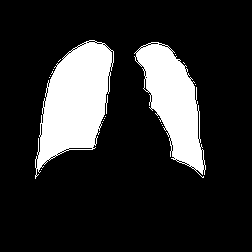

In [0]:
import cv2
from IPython.display import display
import PIL

data = unet_data.get_batch_from_dir()
display(PIL.Image.fromarray((np.array(data[0][0], dtype=np.uint8)*255).reshape(252, 252)).convert("RGB"))


In [0]:

# Authors: Wezley Sherman
#
# Reference Attributes: U-Net: Convolutional Networks for Biomedical Image Segmentation
# Authors: Olaf Ronneberger, Philipp Fischer, and Thomas Brox
#
# This class is a part of the BSSCS Net Framework to import DICOM images and batch them for the UNET
#
# BSSCS Docs Importer location: TBD
#
# Citation:
# Ronneberger, et al. “U-Net: Convolutional Networks for Biomedical Image Segmentation.” 
#     [Astro-Ph/0005112] A Determination of the Hubble Constant from Cepheid Distances and a Model of the Local Peculiar Velocity Field, 
#     American Physical Society, 18 May 2015, arxiv.org/abs/1505.04597.
# Site:
# https://arxiv.org/pdf/1505.04597.pdf
import tensorflow as tf
from google.colab import drive
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file

class BSSCS_UNET:
  def __init__(self, iterations, batch_size, data_class, labels_shape=[None, 1], learning_rate=0.0001):
    self.learning_rate = learning_rate
    self.iterations = iterations
    self.batch_size = batch_size
    self.data_class = data_class
    self.labels_shape = labels_shape


  def generate_unet_arch(self, input):
    ''' Handles generating a TF Implementation of a UNET utilizing the architecture discussed in
    "U-Net: Convolutional Networks for Biomedical Image Segmentation" by Ronneberger, Fischer, and Brox

    The architecture for the UNET is not ours and all accrediation goes to Olaf Ronneberger, Philipp Fischer, and Thomas Brox. 
    We are not claiming any ownership for the architecture. 
    Implementing the UNET arch is comparable to implementing selection sort.

    tf.layers.conv2d docs: https://www.tensorflow.org/api_docs/python/tf/layers/conv2d
    tf.layers.conv2d_transpost for up convolutions: https://www.tensorflow.org/api_docs/python/tf/layers/conv2d_transpose
    tf.concat for the copy and crop methods: https://www.tensorflow.org/api_docs/python/tf/concat
    tf.slice for cropping the tensors: https://www.tensorflow.org/api_docs/python/tf/slice
    Hopefully I implemented this correctly  ¯\_(ツ)_/¯

    Quick guide on cropping a tensor -..

    So after some research through the doc's I found out that we can't just crop it as if it were an image, because we are dealing with Tensors (matricies of data).

    In order to crop a tensor we must use TensorFlow's slice function (https://www.tensorflow.org/api_docs/python/tf/slice)

    Here we are cropping the convolutional layer we are upsampling to be the size of the convolutional layer we are concating to. 
    I'm starting at the base coordinates for the tensor object, and am cropping JUST the images (or filters). Thus why we have [-1, size_x, size_y, -1]. 
    The '-1' values are there to ensure we are keeping the remaining elements of the dimension (AKA our batch size and number of filters) . 
    From TF Docs on the -1 values: " If size[i] is -1, all remaining elements in dimension i are included in the slice. In other words, this is equivalent to setting: size[i] = input.dim_size(i) - begin[i]"

    Once the tensor is properly cropped (Where each filter is the same size as the tensor we are copying into), we can concat the tensors. 
    This allows us to copy in all of the previous filters into the current tensor. The final shape will be: [Batch, Img_X, Img_Y, [Filters_A + Filters_B]]
    '''
    # first block in UNET --> Concat with the final block
    convolution_layer_1 = tf.layers.conv2d(inputs=input, filters=64, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    convolution_layer_2 = tf.layers.conv2d(inputs=convolution_layer_1, filters=64, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    max_pooling_layer_1 = tf.layers.max_pooling2d(inputs=convolution_layer_2, pool_size=[2, 2], strides=1, padding="VALID")

    # second block in UNET --> Concat with second to final block
    convolution_layer_3 = tf.layers.conv2d(inputs=max_pooling_layer_1, filters=128, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    convolution_layer_4 = tf.layers.conv2d(inputs=convolution_layer_3, filters=128, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    max_pooling_layer_2 = tf.layers.max_pooling2d(inputs=convolution_layer_4, pool_size=[2, 2], strides=1, padding="VALID")

    # third block in UNET --> Concat with third from final block
    convolution_layer_5 = tf.layers.conv2d(inputs=max_pooling_layer_2, filters=256, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    convolution_layer_6 = tf.layers.conv2d(inputs=convolution_layer_5, filters=256, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    max_pooling_layer_3 = tf.layers.max_pooling2d(inputs=convolution_layer_6, pool_size=[2, 2], strides=1, padding="VALID")

    # fourth block in UNET --> Concat with fourth from final block
    convolution_layer_7 = tf.layers.conv2d(inputs=max_pooling_layer_3, filters=512, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    convolution_layer_8 = tf.layers.conv2d(inputs=convolution_layer_7, filters=512, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    max_pooling_layer_4 = tf.layers.max_pooling2d(inputs=convolution_layer_8, pool_size=[2, 2], strides=1, padding="VALID")

    # middle UNET block
    convolution_layer_9 = tf.layers.conv2d(inputs=max_pooling_layer_4, filters=1024, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    convolution_layer_10 = tf.layers.conv2d(inputs=convolution_layer_9, filters=1024, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    convolution_up_1 = tf.layers.conv2d_transpose(inputs=convolution_layer_10, filters=1024, kernel_size=[2, 2], strides=1, padding="SAME")

    # fourth from last 
    convolution_layer_8 = tf.slice(convolution_layer_8, [0, 0, 0, 0], [-1, convolution_up_1.shape[1], convolution_up_1.shape[2], -1])
    concat_layer_1 = tf.concat([convolution_up_1, convolution_layer_8], axis=3) # Note: Experiment with the axis to ensure it is correct. Are we copying the batches or the filters? -- However; different axis's cause an error.
    # print(concat_layer_1.shape) # Comes out to be [Batch_Size, Image_X, Image_Y, (Filters_Conv_8 + Filters_Conv_Up_1)]
    convolution_layer_11 = tf.layers.conv2d(inputs=concat_layer_1, filters=512, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    convolution_layer_12 = tf.layers.conv2d(inputs=convolution_layer_11, filters=512, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    convolution_up_2 = tf.layers.conv2d_transpose(inputs=convolution_layer_12, filters=512, kernel_size=[2, 2], strides=1, padding="SAME")


    # third from last
    convolution_layer_6 = tf.slice(convolution_layer_6, [0, 0, 0, 0], [-1, convolution_up_2.shape[1], convolution_up_2.shape[2], -1])
    concat_layer_1 = tf.concat([convolution_up_2, convolution_layer_6], axis=3)
    convolution_layer_13 = tf.layers.conv2d(inputs=convolution_up_2, filters=256, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    convolution_layer_14 = tf.layers.conv2d(inputs=convolution_layer_13, filters=256, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    convolution_up_3 = tf.layers.conv2d_transpose(inputs=convolution_layer_14, filters=256, kernel_size=[2, 2], strides=1, padding="SAME")

    # second from last
    convolution_layer_4 = tf.slice(convolution_layer_4, [0, 0, 0, 0], [-1, convolution_up_3.shape[1], convolution_up_3.shape[2], -1])
    concat_layer_1 = tf.concat([convolution_up_3, convolution_layer_4], axis=3)
    convolution_layer_15 = tf.layers.conv2d(inputs=convolution_up_3, filters=256, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    convolution_layer_16 = tf.layers.conv2d(inputs=convolution_layer_15, filters=128, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    convolution_up_4 = tf.layers.conv2d_transpose(inputs=convolution_layer_16, filters=128, kernel_size=[2, 2], strides=1, padding="SAME")

    # last block
    convolution_layer_2 = tf.slice(convolution_layer_2, [0, 0, 0, 0], [-1, convolution_up_4.shape[1], convolution_up_4.shape[2], -1])
    concat_layer_1 = tf.concat([convolution_up_4, convolution_layer_2], axis=3)
    convolution_layer_17 = tf.layers.conv2d(inputs=convolution_up_4, filters=128, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    convolution_layer_18 = tf.layers.conv2d(inputs=convolution_layer_17, filters=64, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    convolution_layer_19 = tf.layers.conv2d(inputs=convolution_layer_18, filters=64, kernel_size=[3, 3], strides=1, padding="SAME", activation=tf.nn.relu)
    convolution_up_5 = tf.layers.conv2d_transpose(inputs=convolution_layer_19, filters=1, kernel_size=[1, 1], strides=1, padding="SAME")
    print(convolution_up_5.shape)
    return convolution_up_5 #tf.layers.conv2d(inputs=convolution_up_5, filters=1, kernel_size=[1,1], strides=1, padding="SAME", activation=tf.nn.sigmoid)

  def create_regressor(self, input): 
    ''' Handles creating the regressor for the UNET classification

        Parameters:
          - input -- input layer (flattened layer from UNET) 
        Returns:
          - Tensor -- last layer in the regressor
    '''
    reg_input = tf.layers.dense(inputs=input, units=504, activation=tf.nn.relu)
    reg_hidden = tf.layers.dense(inputs=reg_input, units=800, activation=tf.nn.relu)
    reg_hidden1 = tf.layers.dense(inputs=reg_hidden, units=1000, activation=tf.nn.relu)
    reg_hidden2 = tf.layers.dense(inputs=reg_hidden1, units=1500, activation=tf.nn.relu)
    reg_out = tf.layers.dense(inputs=reg_hidden2, units=28)
    return reg_out

  def create_loss(self, input, labels):
    ''' Handles creating a loss function and returning it to the optimizer

      Parameters:
        - Input: The final layer in the graph we are computing the loss for
        - Labels: The labels for the batch we are computing the loss for

      Returns:
        - Defined loss function

      TensorFlow documentation: 
      https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2
    '''
    return tf.nn.softmax_cross_entropy_with_logits_v2(logits=input, labels=labels)

  def create_unet_loss(self, input_est, input_mask):
    ''' Handles creating a loss function and returning it to the optimizer

      Parameters:
        - Input: The final layer in the graph we are computing the loss for
        - Labels: The labels for the batch we are computing the loss for

      Returns:
        - Defined loss function

    '''
    return tf.reduce_mean(tf.square(input_est - input_mask))#tf.losses.softmax_cross_entropy(input_mask, input_est)
  
  def create_optimizer(self, input_est, input_mask):
    '''

      TensorFlow documentation: 
      https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer
    '''
    loss = self.create_unet_loss(input_est, input_mask)
    return tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(loss)

  def train_unet(self):
    ''' Handles training a UNET based off the data fed to it
    '''

    print(self.batch_size)
    # This is where I would put my loss and optimization functions -..
    # ..
    # ..
    # IF I HAD ONE!
    #
    # Meme Reference: https://www.youtube.com/watch?v=ciWPFvLS5IY
    #
    # On a serious note -.. Here is where we will plug in the deep regressor once that's built.
    # After a UNET run the image will be passed to the deep regressor.
    # The regressor will contain the loss function we are optimizing to.
    tf.reset_default_graph()
    input_ph = tf.placeholder(tf.float32, shape=[None, 256, 256, 1]) # Placeholder vals were given by paper in initial layer -- these numbers were referenced from the paper.
    conv_input = self.generate_unet_arch(input_ph)
    labels_placeholder = tf.placeholder(tf.float32, shape=self.labels_shape)
    mask_placeholder = tf.placeholder(tf.float32, shape=[None, 252, 252, 1])
    optimizer = self.create_optimizer(conv_input, mask_placeholder)
    loss = self.create_unet_loss(conv_input, mask_placeholder)
    
    unet_save = tf.train.Saver()
    saved_graph = tf.train.import_meta_graph('/unet/unet.ckpt.meta')
    with tf.Session() as session:
      tf.global_variables_initializer().run()
      self.load_graph(saved_graph, session, '/unet/unet.ckpt')
      tf.local_variables_initializer().run()
      for iteration in range(0, self.iterations): # counts for epochs -- or how many times we go through our data
        for batch in range(0, self.batch_size):
          y_b, X_b, _ = self.data_class.get_batch_from_dir()
          #print("X shape: ", X_b)
          #print("Y shape: ", y_b)
          print("next batch")
          session.run(optimizer, feed_dict={input_ph:X_b, mask_placeholder:y_b})
        if iteration % 2 == 0:
          print("Current Tensors")
         # for tensor in tf.get_default_graph().as_graph_def().node:
          #  print(tensor)
          print("Iteration: ", iteration)
          it_loss = session.run(loss, feed_dict={input_ph:X_b, mask_placeholder:y_b})
          lungs = session.run(conv_input, feed_dict={input_ph: X_b})
          print(lungs.shape)
          display(PIL.Image.fromarray((np.array(lungs[0])*255).reshape(252, 252)).convert("RGB"))
          display(PIL.Image.fromarray(np.array(X_b[0], dtype=np.uint8).reshape(256, 256)).convert("RGB"))
          display(PIL.Image.fromarray((np.array(y_b[0], dtype=np.uint8)*255).reshape(252, 252)).convert("RGB"))
          #labels = session.run(classifier, feed_dict={input_ph: X_b})
          #print(self.save_graph(unet_save, session, "output"))
          #print("Predicted labels: ", labels)
          #print("Labels actual: ", y_b)
          # Evaluate mse loss here and print the value
          print("Passed 100 iterations with mse: ", it_loss)
        if iteration % 100 == 0:
          print("Saving to drive")
          self.save_graph(unet_save, session, '/content/gdrive/My Drive/unetSave/unet', iteration)



  def generalize_prediction(output):
    ''' Handles generalizing UNET outputs to the labels so that we can better understand the predictions.
        If the prediction is under 50% then we mark it as 0, otherwise keep the value.

        Input: 
            - output - array of outputs based off labels from UNET

        Return:
            - return_prediction - array of normalized outputs from output input
    '''
    return_prediction = []
    for prediction in output:
      if(prediction > 0.5):
        return_prediction.append(prediction)
      else:
        return_prediction.append(0)

    return return_prediction

  def test_unet(self, graph_out, input_x):
    ''' Runs a trained UNET through an evaluation/test phase to detect errors

        Parameters:
          - graph_out: conv2d_tranpose tensor - The last layer in the graph
          - input_x: image_arr  - Image array of shape [None, x, y, 1]

        Returns:
          - output: Returns the output of the unet graph
    '''
    with tf.Session() as session:
      output = session.run(graph_out, feed_dict={input:input_x})

    return output

  def save_graph(self, unet_save, session, path, step):
    ''' Saves a UNET graph
        
        Handles saving a UNET Graph to a specified path.
        
        Inputs:
          - unet_save -- TF Saver instance
          - session -- TF Session instance
          - path -- path to save location
        
        Returns:
          - String -- path to output unet
          
          
        Save referenced from TensorFlow Documentation:
        - https://www.tensorflow.org/guide/saved_model
    '''
    return unet_save.save(session, path, step)

  def load_graph(self, unet_save, session, path):
    ''' Loads a UNET graph
    
        Inputs:
          - unet_save -- TF Saver instance
          - session -- TF Session instance
          - path -- path to save location
        
        Returns:
          - None
   
        Load referenced from TensorFlow Documentation:
        - https://www.tensorflow.org/guide/saved_model
    '''
    #print("Tensors being loaded: ")
    #print_tensors_in_checkpoint_file(tf.train.latest_checkpoint(str(path)), all_tensors=True, tensor_name='')
    return unet_save.restore(session, path)


No CSV
500
10
(?, 252, 252, 1)
INFO:tensorflow:Restoring parameters from /unet/unet.ckpt
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
Current Tensors
Iteration:  0
(2, 252, 252, 1)


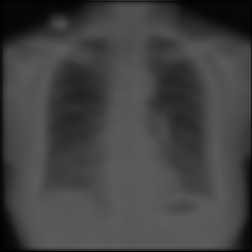

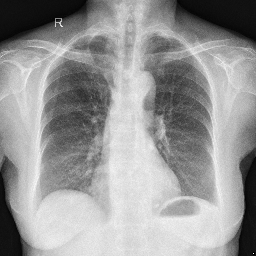

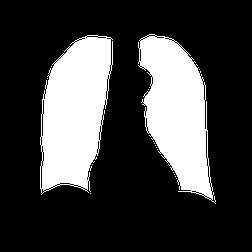

Passed 100 iterations with mse:  0.23131633
Saving to drive
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
Current Tensors
Iteration:  2
(2, 252, 252, 1)


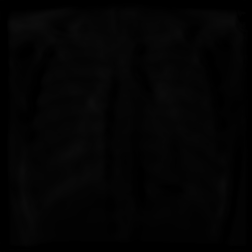

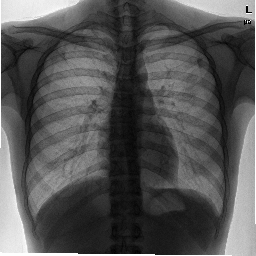

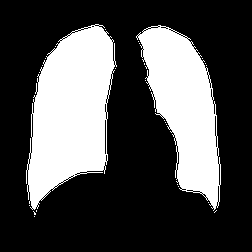

Passed 100 iterations with mse:  0.26150206
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
next batch
Current Tensors
Iteration:  4
(2, 252, 252, 1)


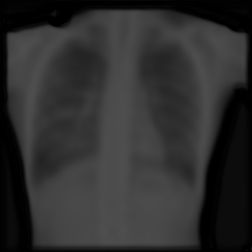

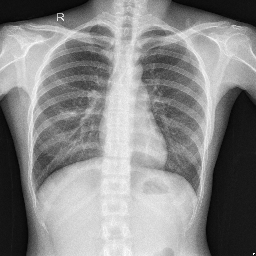

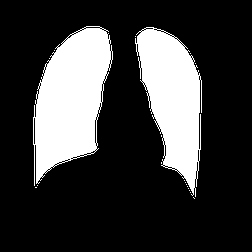

Passed 100 iterations with mse:  0.21324542
next batch
next batch
next batch
next batch


In [0]:
import cv2
from IPython.display import display
import PIL

def test_unet_training(image_path, csv_path, batch_size, iterations):
  unet_data = UNET_DATA(label_classes=None, images_path="data_train/Lung Segmentation")
  unet_data.data_dictionary = unet_data.fetch_images_and_masks_from_dir("masks", "ClinicalReadings", "CXR_png")  
  unet = BSSCS_UNET(iterations, batch_size, unet_data, labels_shape=[None, 28])
  unet.train_unet()

test_unet_training(image_path="data_train", csv_path="train.csv", batch_size=10, iterations=3100)


In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

In [0]:
!cp -a '/content/gdrive/My Drive/unetSave/.' /unet/

In [10]:
!ls 'gdrive/My Drive/unetSave'
!mkdir /unet
!ls /unet

checkpoint  unet.ckpt.data-00000-of-00001  unet.ckpt.index  unet.ckpt.meta
mkdir: cannot create directory ‘/unet’: File exists
checkpoint  unet.ckpt.data-00000-of-00001  unet.ckpt.index  unet.ckpt.meta


In [0]:
!tensorboard --logdir='/'